# Exploring How to Fit Model with Concentration-dependent Diffusivity

In [16]:
%load_ext autoreload
%autoreload 2

# sets plotting font to Arial
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

# imports standard libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# imports custom libraries
import sys
sys.path.append('../../libs/')
import flow
import polyco2
import finitediff as fd
# plotting
import plot.diffn as pltd
import plot.bubble as pltb
import plot.genl as pltg

sys.path.append('../src/')
import diffn
import bubble
import bubbleflow
import analytics as an


# CONVERSIONS
from conversions import *
# CONSTANTS
from constants import *

### PARAMETERS ###
# directory template containing data files
data_dir_tmp = '../input/ppg_co2/20211202_72bar/*'
# data filename
data_filename = 'data.pkl'
# data for polyol-CO2 mixture 
# make this on Wang group server with `bi_surf`--read README.txt and copy 1k3f_22c.csv
polyol_data_file = '../input/3k2f_31c.csv'
# equation of state data for CO2 at desired temperature 
eos_co2_file = '../input/eos_co2_25-0C.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# flow parameters for experiments in 20200905_80bar folder
# viscosity of inner and outer streams [Pa.s]
eta_i = 0.25 # rough estimate of VORANOL 360 + CO2 dissolved so should be lower
eta_o = 4.815
# length of observation capillary [m]
L = 10E-2
# outer stream radius [m]
R_o = 150E-6
Q_o = 200 # outer stream flow rate, input to ISCO 260 D [uL/min]
# inner stream flow rate [uL/min]
Q_i = 100
# saturation pressure [Pa]
p_s = 80E5
# distance down capillary at which measurements were taken in videos of effect of flow rate on 20200905_80bar [m]
d = 0.096

# bubble growth model parameters
dt = 1E-12 # [s]
R_nuc = 5E-6 # [m] arbitrary bubble size for comparing models

# grid parameters
R_max = 150E-6 # outer radius [m]

# diffusion model parameters 
dc_c_s_frac = 0.01 # step size in concentration for estimating dD/dc as a fraction of saturation concentration

# plot parameters
t_fs = 18
ax_fs = 16
tk_fs = 14
l_fs = 12

In [18]:
# computes inner stream radius [m] and velocity [m/s]
dp, R_i, v = flow.get_dp_R_i_v_max(eta_i, eta_o, L, Q_i*uLmin_2_m3s, Q_o*uLmin_2_m3s, R_o, SI=True)
# inlet pressure [Pa]
p_in = P_ATM - dp
# nucleation time [s]
t_nuc = d/v

In [19]:
# frame rate [fps]
fps = 11184

# initial and final frames with bubbles (inclusive)
f_i = 9510
f_f = 9527
R_bubble = 8.5E-6 # bubble radius in first frame [m]
x_bubble = d # distance traveled along channel [m]
t_bubble = x_bubble / v # time bubble had traveled down channel [s]

# additional bubbles
f_bubbles = [i for i in range(f_i+1, f_f+1)]
R_bubbles = np.asarray([8.8, 8.8, 9, 9.8, 9.65, 10, 9.65, 10.15, 10.3, 10.3, 10.5, 11.15, 11.25, 
                      11.8, 11.55, 12.15, 12.8]) * um_2_m
t_bubbles = np.asarray([t_bubble + (f - f_i)/fps for f in f_bubbles])

In [20]:
filepath_D_c='../input/1k3f_30c_D_c_power_law.csv'
df_D = pd.read_csv(filepath_D_c)
D0, A_p, k_p = df_D['p']
D0, A_dp, k_dp = df_D['dp']

params_p = (D0, A_p, k_p)

def D_p(c):
    """
    Power-law fit for D(c) fitted to *pressurization* data of 1k3f @ 30c
    (see 20201124_1k3f_D_vs_rho_co2.ipynb).
    """
    return D0 + A_p * c**k_p


def D_dp(c):
    """
    Power-law fit for D(c) fitted to *depressurization* data of 1k3f @ 30c (see
    20201124_1k3f_D_vs_rho_co2.ipynb).
    """
    return D0 + A_dp * c**k_dp


# simulation parameters
R_i = 40E-6
N0 = 50
D_max = D_p(500) # [m^2/s]
dt_sheath = 0.5*(R_max/N0)**2/D_max
half_grid = True

    
D_fn = D_p

0% complete, t = 0.000 ms.
10% complete, t = 29.156 ms.
20% complete, t = 58.219 ms.
30% complete, t = 87.375 ms.
40% complete, t = 116.438 ms.
50% complete, t = 145.594 ms.
60% complete, t = 174.656 ms.
70% complete, t = 203.813 ms.
80% complete, t = 232.875 ms.
regridding
90% complete, t = 261.998 ms.
0% complete, t = 0.000 ms.
10% complete, t = 29.156 ms.
20% complete, t = 58.219 ms.
30% complete, t = 87.375 ms.
40% complete, t = 116.438 ms.
50% complete, t = 145.594 ms.
60% complete, t = 174.656 ms.
70% complete, t = 203.813 ms.
80% complete, t = 232.875 ms.
90% complete, t = 262.031 ms.
regridding
t_nuc = 270.000 ms and error in R is 2.4095.
0% complete, t = 0.000 ms.
10% complete, t = 29.156 ms.
20% complete, t = 58.219 ms.
30% complete, t = 87.375 ms.
40% complete, t = 116.438 ms.
50% complete, t = 145.594 ms.
60% complete, t = 174.656 ms.
70% complete, t = 203.813 ms.
80% complete, t = 232.875 ms.
90% complete, t = 262.031 ms.
regridding
t_nuc = 275.000 ms and error in R is 1.3

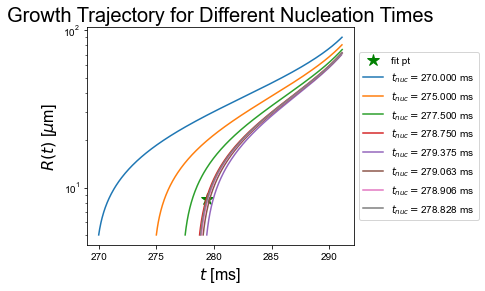

In [23]:
# collects relevant parameters
eps_params = (dt, p_s, R_nuc, L, p_in, v, polyol_data_file, eos_co2_file)

eta_ratio = eta_i / eta_o 

growth_fn = bubbleflow.sheath_incompressible
i_t = 2 # index of t_bub in output of growth_fn
i_R = 10 # index of R in output of growth_fn
sigma_R = 0.03 # tolerance of error in radius
# groups arguments for growth model
N = 200
R_max = R_o
args = [eps_params, R_max, N, R_i, dt_sheath]
dict_args = {'remesh_fn' : diffn.manage_grid_halving, 
             'remesh_params' : {'pts_per_grad' : 5, 'interp_kind' : 'quadratic'}, 'D_fn' : D_fn,
             'remesh_freq' : 100, 'alpha' : 0.3, 'eta_ratio' : eta_ratio}
    
i_t_nuc = 0

# increases maximum iterations
max_iter = 15

# bounds on nucleation time
t_nuc_lo = 0.26 # [s]
t_nuc_hi = 0.28 # [s]

# opens figure to show results of different guesses for bubble nucleation time
fig = plt.figure()
ax = fig.add_subplot(111)

# uses modified shooting method to estimate the nucleation time
t_nuc, output = an.fit_growth_to_pt(t_bubble, R_bubble, t_nuc_lo, t_nuc_hi, growth_fn, args,
                     i_t_nuc, sigma_R=sigma_R, ax=ax, max_iter=max_iter, i_t=i_t, i_R=i_R, dict_args=dict_args)

# unpacks output
t_flow, c, t_bub, m, D, p, p_bub, if_tension, c_bub, c_bulk, R, \
            rho_co2, v, dr_list = output
# groups results for plotting
props_list_fit = (R, m, p, p_bub, rho_co2, if_tension)